Assign final cell type labels and visualize them.

INFO: Run with conda environment sc-mar2021

# 0. Load packages

In [1]:
import os
import sys
import glob
import re

import anndata
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

In [2]:
plt.rcParams['figure.figsize']=(20,12) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.8.0
scanpy      1.8.1
sinfo       0.3.4
-----
PIL                         8.3.2
anyio                       NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      NA
cached_property             1.5.2
certifi                     2021.05.30
cffi                        1.14.6
chardet                     4.0.0
charset_normalizer          2.0.0
colorama    

In [3]:
sc.settings.set_figure_params(dpi=600, frameon=False)
sc.set_figure_params(dpi=600)
sc.set_figure_params(figsize=(6, 6))

In [4]:
sys.path.insert(0,'..')
import paths_downsampling as paths
p = paths.get_paths()
print(p)

{'basedir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/', 'rawdir_RNA': '/psycl/g/mpsngs/HiSeq_Helmholtz/20210324_Anna_Froehlich_10X_RNAseq/03_downsampled/', 'figdir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/figures/', 'writedir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/scanpy_adata/', 'allendir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/reference_data/allen_human/'}


# 1. Read and inspect data

In [5]:
adata = sc.read(p['writedir']+'adata_labelTransfer_celltypes_samplesFilt_AnnaAnnotation.h5ad')

In [6]:
# mitochondrial genes left --> remove them later
adata[:,adata.var['mito']].var

gene_ids  mito  mean_counts  log1p_mean_counts  \
MT-ND1   ENSG00000198888  True     0.709104           0.535969   
MT-ND2   ENSG00000198763  True     0.637519           0.493182   
MT-CO1   ENSG00000198804  True     1.500248           0.916390   
MT-CO2   ENSG00000198712  True     1.504916           0.918255   
MT-ATP8  ENSG00000228253  True     0.242534           0.217153   
MT-ATP6  ENSG00000198899  True     1.328514           0.845230   
MT-CO3   ENSG00000198938  True     1.188131           0.783048   
MT-ND3   ENSG00000198840  True     1.021263           0.703722   
MT-ND4L  ENSG00000212907  True     0.286334           0.251797   
MT-ND4   ENSG00000198886  True     1.163907           0.771915   
MT-ND5   ENSG00000198786  True     0.370251           0.314994   
MT-ND6   ENSG00000198695  True     0.015606           0.015485   
MT-CYB   ENSG00000198727  True     0.978853           0.682517   

         pct_dropout_by_counts  total_counts  log1p_total_counts  n_cells  \
MT-ND1               41.217057  6.352391e+05           13.361758   494579   
MT-ND2               43.487905  5.711103e+05           13.255340   475303   
MT-CO1               19.288528  1.343972e+06           14.111140   682724   
MT-CO2               19.932510  1.348154e+06           14.114247   677104   
MT-ATP8              70.611710  2.172703e+05           12.288902   247101   
MT-ATP6              23.423451  1.190126e+06           13.989571   647158   
MT-CO3               25.854372  1.064367e+06           13.877892   626303   
MT-ND3               30.368272  9.148808e+05           13.726550   587320   
MT-ND4L              66.117346  2.565079e+05           12.454919   284406   
MT-ND4               25.990559  1.042666e+06           13.857293   624742   
MT-ND5               59.080989  3.316833e+05           12.711939   343761   
MT-ND6               97.588725  1.398012e+04            9.545463    20241   
MT-CYB               31.773779  8.768888e+05           13.684136   575354   

         n_cells_by_counts  highly_variable     means  dispersions  \
MT-ND1              526597             True  1.021337     1.369942   
MT-ND2              506254             True  0.894514     1.201845   
MT-CO1              723040             True  1.988027     2.537238   
MT-CO2              717271             True  2.045812     2.785792   
MT-ATP8             263270             True  0.322492     0.756555   
MT-ATP6             685998             True  1.817025     2.394380   
MT-CO3              664221             True  1.610506     2.109707   
MT-ND3              623784             True  1.416860     1.990299   
MT-ND4L             303532             True  0.390963     0.734554   
MT-ND4              663001             True  1.579613     1.964515   
MT-ND5              366566             True  0.498871     0.852404   
MT-ND6               21601             True  0.026914     0.355121   
MT-CYB              611193             True  1.381955     1.884541   

         dispersions_norm  
MT-ND1           1.151717  
MT-ND2           1.048551  
MT-CO1           1.303963  
MT-CO2           1.663035  
MT-ATP8          1.223425  
MT-ATP6          1.280925  
MT-CO3           1.799234  
MT-ND3           1.558748  
MT-ND4L          1.140961  
MT-ND4           1.506820  
MT-ND5           0.644293  
MT-ND6           0.757777  
MT-CYB           1.885118

In [7]:
# write mitochondrial genes to file --> filter them out during DE analysis
adata[:,adata.var['mito']].var.to_csv(p['basedir']+'tables/mito_genes.csv')

In [12]:
adata.obs['Status'] = adata.obs['Status'].astype('category')

In [ ]:
# Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['leiden_r1', 'leiden_r0.5'], size=500000 /adata.n_obs, frameon=False)#, palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['leiden_r1', 'leiden_r0.5'], size=500000 /adata.n_obs, frameon=True, legend_loc='on data')
sc.pl.umap(adata, color=['celltype_r1'], size=500000 /adata.n_obs, frameon=False)#, palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['Anna_celltypes'], size=500000 /adata.n_obs, frameon=False)#, palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['individual', 'Status'], size=500000 /adata.n_obs, frameon=False)#, palette=sc.pl.palettes.default_64

In [10]:
adata

AnnData object with n_obs × n_vars = 813095 × 26195
    obs: 'sample', 'individual', 'region', 'experiment', 'batch', 'SU.Number', 'Age', 'AgeBin', 'Sex', 'Ethnic.origin', 'Status', 'Classification', 'Classification.detail', 'Trauma.Code', 'Trauma.notes.medical.history', 'PMI', 'Hemisphere', 'Brain.pH', 'RIN', 'Chlorpromazine.equivalent', 'Antidepressants', 'Mode.of.death', 'Manner.of.Death', 'Suicide', 'COD.category', 'positive.Toxicology', 'Antipsychotics', 'Duration.of.psych.illness', 'Antipsychotics.meds.pres', 'Smoking.status', 'Freezer.storage.time..days.', 'alcohol.intake..g.day.past.12.mth.', 'Age.of.onset', 'Agonal.score', 'Main.Batch', '6-Batch', 'Position', 'Group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts', 'n_genes', 'dd_doublet', '

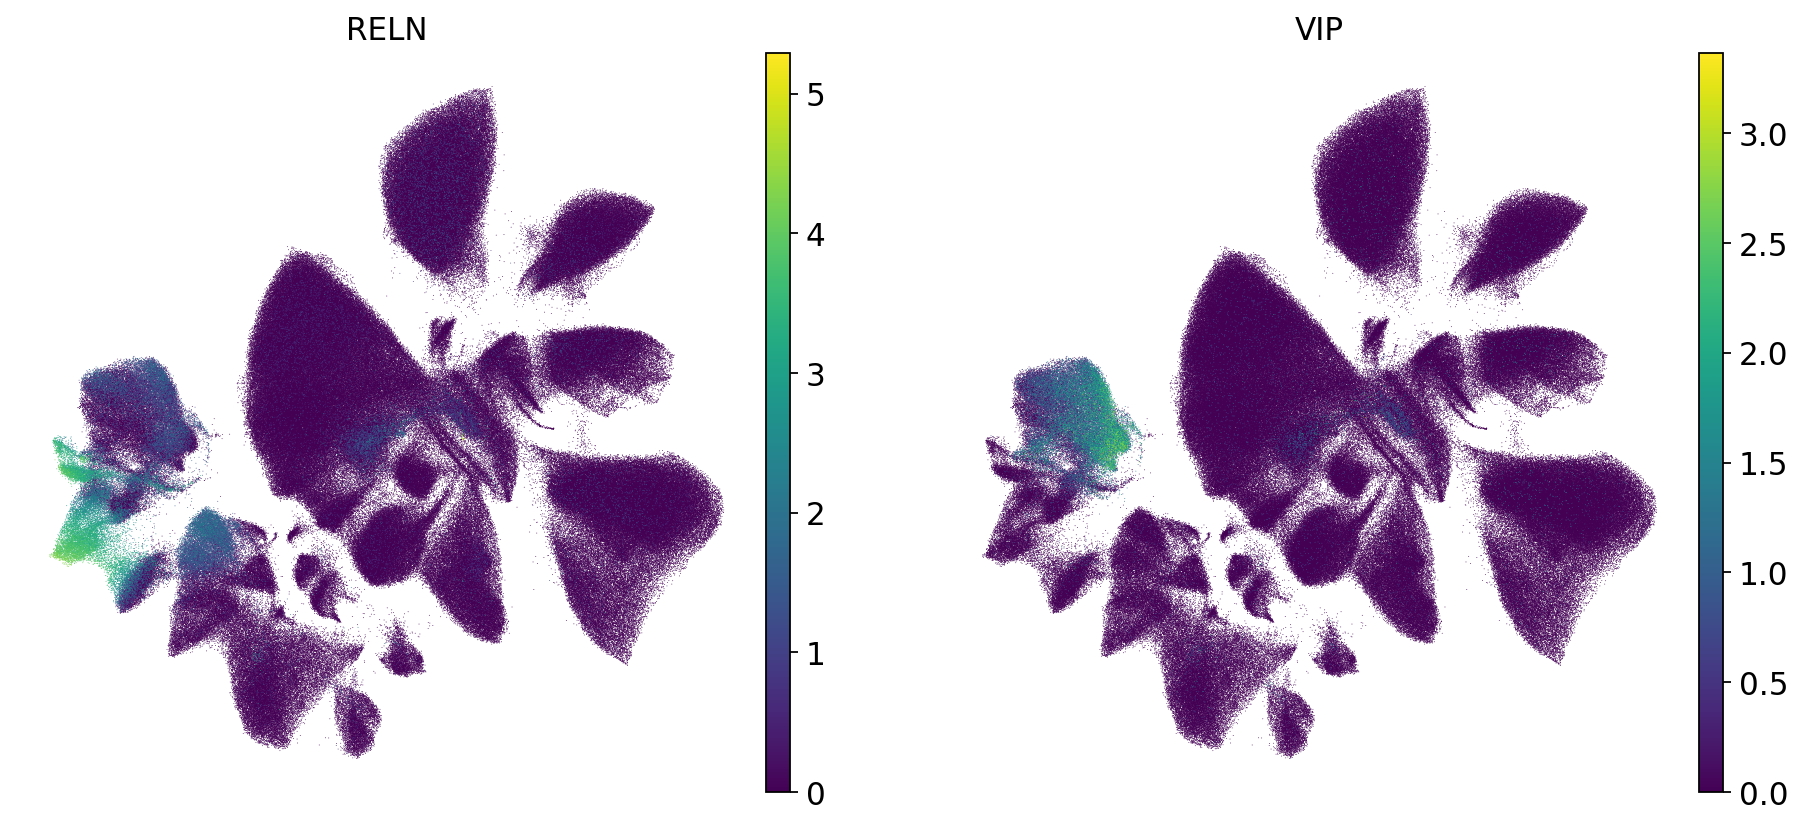

In [11]:
sc.pl.umap(adata, color=["RELN", "VIP"], size=500000 /adata.n_obs, frameon=False)#, palette=sc.pl.palettes.default_64

In [14]:
# reassign cluster 23 and 15 to In_RELN
adata.obs['Anna_celltypes'] = adata.obs['Anna_celltypes'].cat.add_categories(['In_RELN'])
adata.obs['Anna_celltypes'].loc[adata.obs['leiden_r1'].isin(['15','23'])] = 'In_RELN'
adata.obs['Anna_celltypes'].loc[adata.obs['leiden_r1'].isin(['15','23'])]

index
AACAAAGGTCAAGCGA-1-0-0      In_RELN
AACAACCTCTTAGTTC-1-0-0      In_RELN
AACAAGACAATGAGCG-1-0-0      In_RELN
AACAGGGAGTCTCCTC-1-0-0      In_RELN
AACCTTTCAATTGCTG-1-0-0      In_RELN
                             ...   
TTTACCATCGATTGGT-1-91-90    In_RELN
TTTCAGTAGCCAAGCA-1-91-90    In_RELN
TTTGGTTTCCTTACCG-1-91-90    In_RELN
TTTGGTTTCTTTCTAG-1-91-90    In_RELN
TTTGTTGGTGTCTTCC-1-91-90    In_RELN
Name: Anna_celltypes, Length: 24095, dtype: category
Categories (21, object): ['Exc_L2-3', 'Exc_L3-5', 'Exc_L4-6_1', 'Exc_L4-6_2', ..., 'Microglia', 'Oligodendrocyte', 'OPC', 'In_RELN']

In [15]:
# rename Exc_L4-6_THEMIS_LINC00343
adata.obs['Anna_celltypes'] = adata.obs['Anna_celltypes'].cat.add_categories(['Exc_L4-6_3'])
adata.obs['Anna_celltypes'].loc[adata.obs['Anna_celltypes'] == 'Exc_L4-6_THEMIS_LINC00343'] = 'Exc_L4-6_3'

# 2. Get cell type label with maximal overlap per cluster

In [16]:
ctAnna_leidenr1 = pd.crosstab(adata.obs['Anna_celltypes'],adata.obs['leiden_r1'])
ctAnna_leidenr1

leiden_r1            0      1      2      3      4      5      6      7  \
Anna_celltypes                                                            
Exc_L2-3             2  92624      0  62826     20  41613      4      5   
Exc_L3-5             0      0      0     12      0    111      0      0   
Exc_L4-6_1           0      0      0      1      0     17      0      0   
Exc_L4-6_2           0      0      0      4      0     17      0      0   
Exc_L5-6             0      0      0      0      0      1      0      0   
Exc_L5-6_HTR2C       0      0      0      1      0      0      0      0   
Exc_7                3      0     14      0      1    337      1     34   
Exc_20               0      0      0      0      0      1      0      0   
In_LAMP5             0      0      0      0      0      1      4      0   
In_PVALB_Ba          0      0      0      0      0      1      0      0   
In_PVALB_Ch          0      0      0      0      0      0      0      0   
In_SST               0      0      0      0      0      1      0      0   
In_VIP               0      0      0      0      0      6  41673      0   
Astro_FB             0      0     25      0      0      0      0      0   
Astro_PP             1      0  86312      1      5      0      1     33   
Endothelial          0      0      0      0      1      2      0      8   
Microglia            0      0      0      1      0      2      0  38963   
Oligodendrocyte  92738      2      0      1      0      4      0    352   
OPC                  0      2      0      0  45400      1      0      0   
In_RELN              0      0      0      0      0      0      0      0   
Exc_L4-6_3           0      0      0      8      0     15      0      0   

leiden_r1            8      9  ...     19    20    21    22    23    24    25  \
Anna_celltypes                 ...                                              
Exc_L2-3            15     69  ...     21    25    10     5     0    10     4   
Exc_L3-5             0     19  ...      3     0     0     0     0     0     0   
Exc_L4-6_1       36131    294  ...      7     0     0     5     0     1     0   
Exc_L4-6_2          11  34699  ...      7     1     0     0     0     0     0   
Exc_L5-6             2      0  ...      0  7537     0     0     0     0     0   
Exc_L5-6_HTR2C       0      0  ...      0     0     0  4138     0     0     0   
Exc_7                1      2  ...      5     0     0     1     0     1     0   
Exc_20               0      0  ...      0     0     0     0     0     0  1068   
In_LAMP5             0      0  ...      0     0     0     0     0     0     0   
In_PVALB_Ba          0      0  ...      0     0     1    13     0     0     0   
In_PVALB_Ch          0      0  ...      0     0  6706     2     0     0     0   
In_SST               0      0  ...      0     0     0     0     0     0     0   
In_VIP               0      0  ...      0     0     0     0     0     0     0   
Astro_FB             0      0  ...      0     0     0     0     0     0     0   
Astro_PP             4      0  ...      0     0     0     0     0     0     0   
Endothelial          0      0  ...      0     0     0     0     0     0     0   
Microglia            0      0  ...      0     0     0     0     0     0     0   
Oligodendrocyte      0      1  ...      0     0     0     0     0     1     0   
OPC                  0      1  ...      0     0     0     0     0     0     0   
In_RELN              0      0  ...      0     0     0     0  3498     0     0   
Exc_L4-6_3           2      5  ...  11144     1     0     0     0  3279     0   

leiden_r1         26   27  28  
Anna_celltypes                 
Exc_L2-3           0    0   0  
Exc_L3-5           0    0   0  
Exc_L4-6_1         0    0   0  
Exc_L4-6_2         0    0   0  
Exc_L5-6           0    0   0  
Exc_L5-6_HTR2C     0    0   0  
Exc_7              0    0   0  
Exc_20             0    0   0  
In_LAMP5           0    0   0  
In_PVALB_Ba        0    0   0  
In_PVALB_Ch        0    0 

Assigned cell type labels are not consistent with clusters. Here, we do another majority vote, meaning that we assign the cell type with maximal overlap to each cluster.

In [17]:
# get label with maximal overlap per cluster
max_leidenr1 = ctAnna_leidenr1.idxmax(axis=0).to_frame(name = "label")
max_leidenr1 = dict(zip(max_leidenr1.index, max_leidenr1.label))
print(max_leidenr1)

{'0': 'Oligodendrocyte', '1': 'Exc_L2-3', '2': 'Astro_PP', '3': 'Exc_L2-3', '4': 'OPC', '5': 'Exc_L2-3', '6': 'In_VIP', '7': 'Microglia', '8': 'Exc_L4-6_1', '9': 'Exc_L4-6_2', '10': 'In_SST', '11': 'In_PVALB_Ba', '12': 'Astro_FB', '13': 'Exc_7', '14': 'Exc_L2-3', '15': 'In_RELN', '16': 'In_LAMP5', '17': 'Endothelial', '18': 'Exc_L3-5', '19': 'Exc_L4-6_3', '20': 'Exc_L5-6', '21': 'In_PVALB_Ch', '22': 'Exc_L5-6_HTR2C', '23': 'In_RELN', '24': 'Exc_L4-6_3', '25': 'Exc_20', '26': 'In_VIP', '27': 'In_SST', '28': 'Microglia'}


In [18]:
# assign cell type per cluster according to highest overlap
adata.obs['ctAnna_r1'] = adata.obs['leiden_r1'].map(max_leidenr1)

In [19]:
pd.crosstab(adata.obs['ctAnna_r1'],adata.obs['leiden_r1'])

leiden_r1            0      1      2      3      4      5      6      7  \
ctAnna_r1                                                                 
Astro_FB             0      0      0      0      0      0      0      0   
Astro_PP             0      0  86351      0      0      0      0      0   
Endothelial          0      0      0      0      0      0      0      0   
Exc_20               0      0      0      0      0      0      0      0   
Exc_7                0      0      0      0      0      0      0      0   
Exc_L2-3             0  92628      0  62855      0  42130      0      0   
Exc_L3-5             0      0      0      0      0      0      0      0   
Exc_L4-6_1           0      0      0      0      0      0      0      0   
Exc_L4-6_2           0      0      0      0      0      0      0      0   
Exc_L4-6_3           0      0      0      0      0      0      0      0   
Exc_L5-6             0      0      0      0      0      0      0      0   
Exc_L5-6_HTR2C       0      0      0      0      0      0      0      0   
In_LAMP5             0      0      0      0      0      0      0      0   
In_PVALB_Ba          0      0      0      0      0      0      0      0   
In_PVALB_Ch          0      0      0      0      0      0      0      0   
In_RELN              0      0      0      0      0      0      0      0   
In_SST               0      0      0      0      0      0      0      0   
In_VIP               0      0      0      0      0      0  41683      0   
Microglia            0      0      0      0      0      0      0  39395   
OPC                  0      0      0      0  45427      0      0      0   
Oligodendrocyte  92744      0      0      0      0      0      0      0   

leiden_r1            8      9  ...     19    20    21    22    23    24    25  \
ctAnna_r1                      ...                                              
Astro_FB             0      0  ...      0     0     0     0     0     0     0   
Astro_PP             0      0  ...      0     0     0     0     0     0     0   
Endothelial          0      0  ...      0     0     0     0     0     0     0   
Exc_20               0      0  ...      0     0     0     0     0     0  1072   
Exc_7                0      0  ...      0     0     0     0     0     0     0   
Exc_L2-3             0      0  ...      0     0     0     0     0     0     0   
Exc_L3-5             0      0  ...      0     0     0     0     0     0     0   
Exc_L4-6_1       36166      0  ...      0     0     0     0     0     0     0   
Exc_L4-6_2           0  35090  ...      0     0     0     0     0     0     0   
Exc_L4-6_3           0      0  ...  11187     0     0     0     0  3292     0   
Exc_L5-6             0      0  ...      0  7564     0     0     0     0     0   
Exc_L5-6_HTR2C       0      0  ...      0     0     0  4164     0     0     0   
In_LAMP5             0      0  ...      0     0     0     0     0     0     0   
In_PVALB_Ba          0      0  ...      0     0     0     0     0     0     0   
In_PVALB_Ch          0      0  ...      0     0  6717     0     0     0     0   
In_RELN              0      0  ...      0     0     0     0  3498     0     0   
In_SST               0      0  ...      0     0     0     0     0     0     0   
In_VIP               0      0  ...      0     0     0     0     0     0     0   
Microglia            0      0  ...      0     0     0     0     0     0     0   
OPC                  0      0  ...      0     0     0     0     0     0     0   
Oligodendrocyte      0      0  ...      0     0     0     0     0     0     0   

leiden_r1         26   27  28  
ctAnna_r1                      
Astro_FB           0    0   0  
Astro_PP           0    0   0  
Endothelial        0    0   0  
Exc_20             0    0   0  
Exc_7              0    0   0  
Exc_L2-3           0    0   0  
Exc_L3-5           0    0   0  
Exc_L4-6_1         0    0   0  
Exc_L4-6_2         0    0   0  
Exc_L4-6_3         0    0   0  
Exc_L5-6           0    0 

## 2.1 Distribution of cells per sample

### 2.1.1 Distribution of cells per celltype with Exc_7 and Exc_20

In [20]:
cm = sc.metrics.confusion_matrix('ctAnna_r1', 'sample', adata.obs)

In [ ]:
#sc.set_figure_params(figsize=(25, 10))
plt.rcParams['figure.figsize']=(25,10)
plt.figure()
sb.set(font_scale=1.0) 
hm = sb.heatmap(cm, cmap="YlGnBu", linewidths=.5)
#hm.figure.savefig(p["figdir"]+"TAC_Anna_distrCellsPerSample.pdf", bbox_inches = 'tight')

### 2.1.2 Distribution of cells per sample without Exc_7 and Exc_20

In [22]:
adata_filt = adata[adata.obs["ctAnna_r1"] != 'Exc_7']
adata_filt = adata_filt[adata_filt.obs["ctAnna_r1"] != 'Exc_20']

In [ ]:
# absolute values
cm_abs = sc.metrics.confusion_matrix('sample', 'ctAnna_r1', adata_filt.obs, normalize=False)
cm_abs

In [24]:
cm_abs.to_csv(p['basedir'] + 'tables/distrCelltypePerSample_absValues_RELN.csv')

In [25]:
# normalized values
cm = sc.metrics.confusion_matrix('sample', 'ctAnna_r1', adata_filt.obs)

In [ ]:
cm

In [27]:
cm.to_csv(p['basedir'] + 'tables/distrCelltypePerSample_RELN.csv')

In [ ]:
#sc.set_figure_params(figsize=(25, 10))
plt.rcParams['figure.figsize']=(25,10)
plt.figure()
sb.set(font_scale=1.0) 
hm = sb.heatmap(cm.T, cmap="YlGnBu", linewidths=.5)
#hm.figure.savefig(p["figdir"]+"TAC_Anna_distrCellsPerSample.pdf", bbox_inches = 'tight')

# 3. Save object with new cell types

In [29]:
#Write data
adata.write(p['writedir']+'adata_labelTransfer_celltypes_samplesFilt_AnnaAnnotation_RELN.h5ad')

... storing 'ctAnna_r1' as categorical


In [30]:
# save adata.obs to csv file
#compression_opts = dict(method='zip',
#                        archive_name='adata_labelTransfer_celltypes_samplesFilt_AnnaAnnotation_obs.csv')  
#adata.obs.to_csv(p['writedir']+'adata_labelTransfer_celltypes_samplesFilt_AnnaAnnotation_obs.zip',
#          compression=compression_opts)  
adata.obs.to_csv(p['writedir']+'adata_labelTransfer_celltypes_samplesFilt_AnnaAnnotation_RELN_obs.csv')

In [31]:
# remove adata.obs
del adata.obs

In [32]:
adata.layers

Layers with keys: counts, sct_corrected

In [33]:
#Write data
adata.write(p['writedir']+'adata_labelTransfer_celltypes_samplesFilt_AnnaAnnotation_RELN_woObs.h5ad')

# 4. Plots gene expression

In [5]:
adata = sc.read(p['writedir']+'adata_labelTransfer_celltypes_samplesFilt_AnnaAnnotation_RELN.h5ad')

In [6]:
adata = adata[adata.obs["ctAnna_r1"] != 'Exc_7']
adata = adata[adata.obs["ctAnna_r1"] != 'Exc_20']

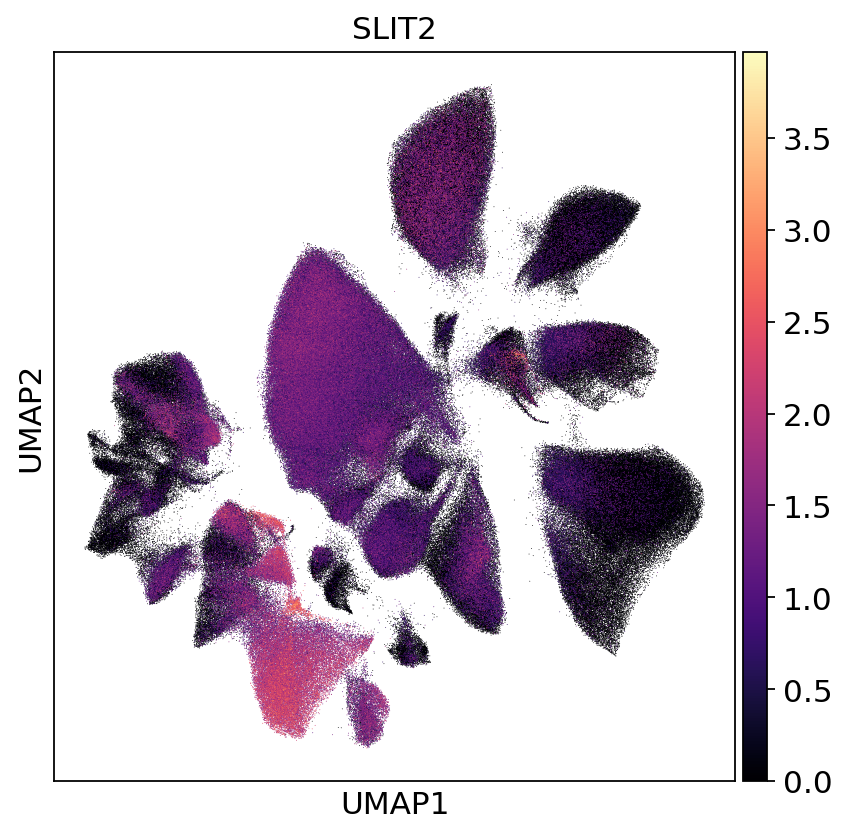

In [7]:
sc.pl.umap(adata, color=["SLIT2"], 
           size=500000 /adata.n_obs, 
           frameon=True, 
           color_map = 'magma',
           save="_GeneExamples_SLIT2.pdf")

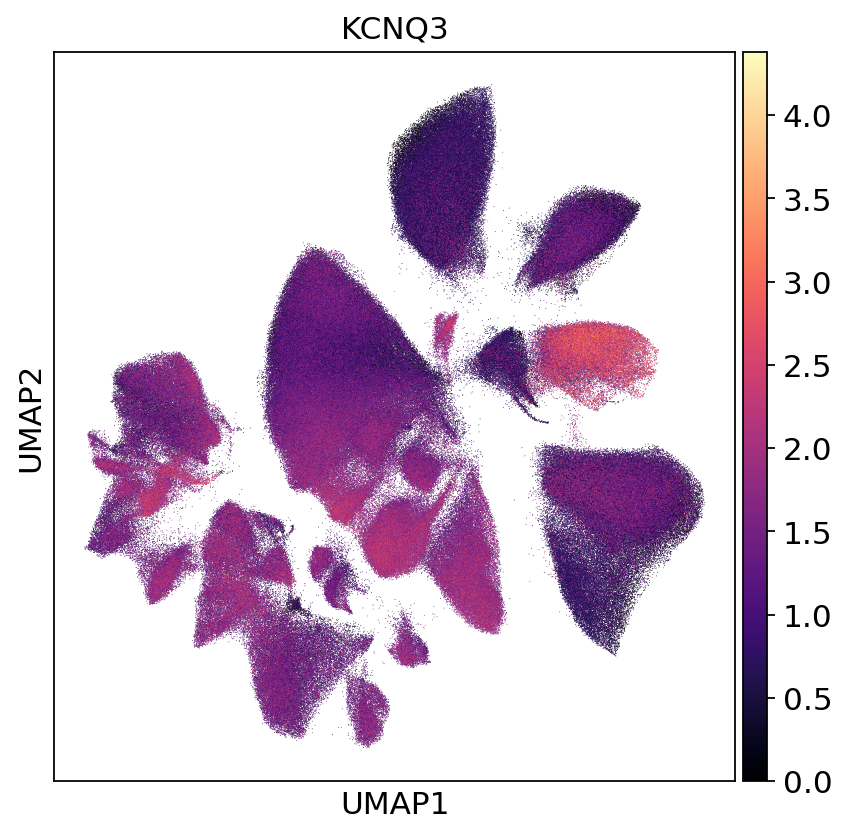

In [8]:
sc.pl.umap(adata, color=["KCNQ3"], 
           size=500000 /adata.n_obs, 
           frameon=True, 
           color_map = 'magma',
           save="_GeneExamples_KCNQ3.pdf")

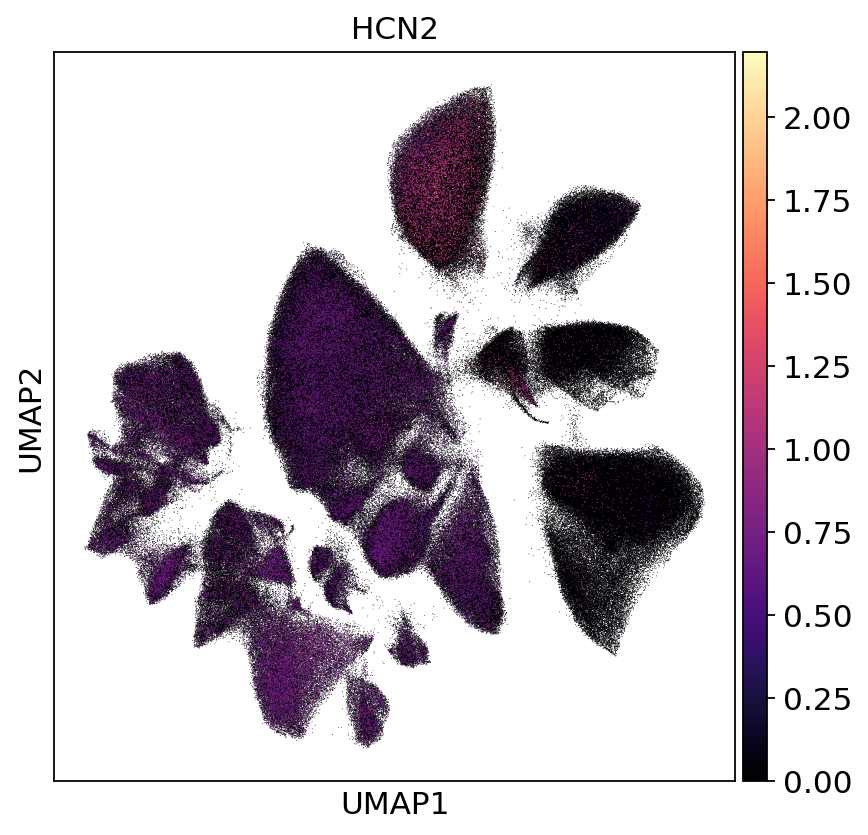

In [9]:
sc.pl.umap(adata, color=["HCN2"], 
           size=500000 /adata.n_obs, 
           frameon=True, 
           color_map = 'magma',
           save="_GeneExamples_HCN2.pdf")

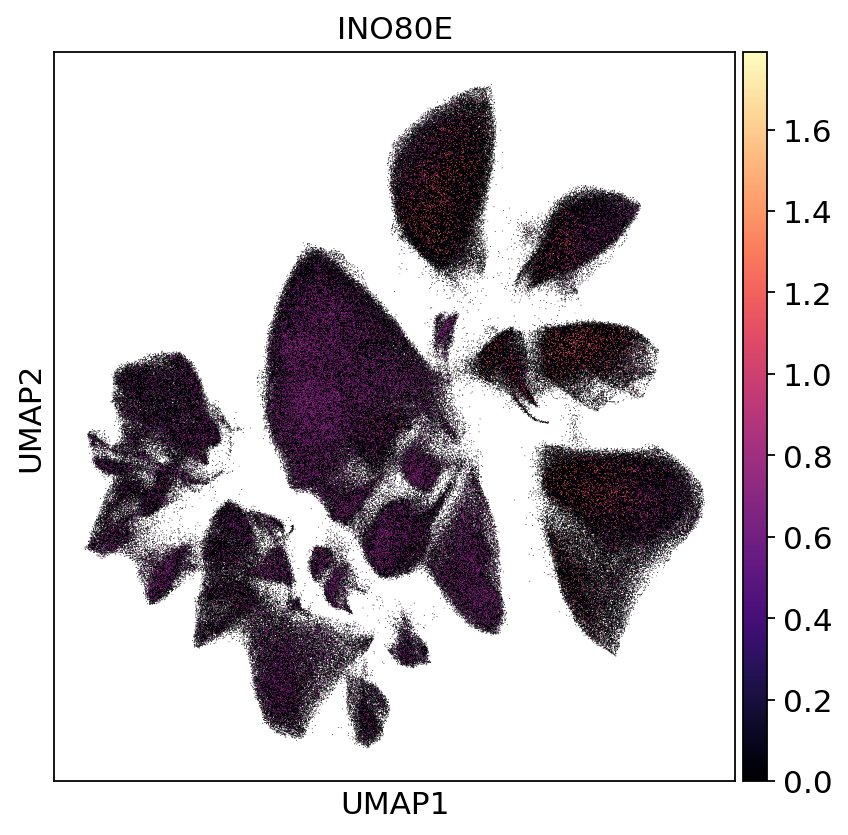

In [10]:
sc.pl.umap(adata, color=["INO80E"], 
           size=500000 /adata.n_obs, 
           frameon=True, 
           color_map = 'magma',
           save="_GeneExamples_INO80E.pdf")

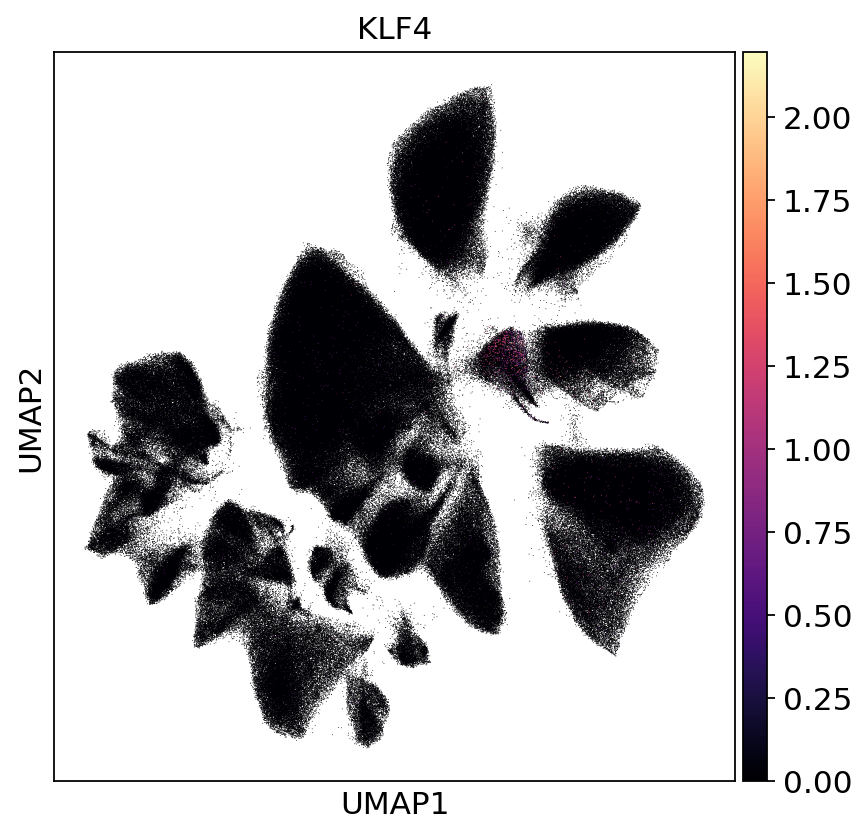

In [11]:
sc.pl.umap(adata, color=["KLF4"], 
           size=500000 /adata.n_obs, 
           frameon=True, 
           color_map = 'magma',
           save="_GeneExamples_KLF4.pdf")

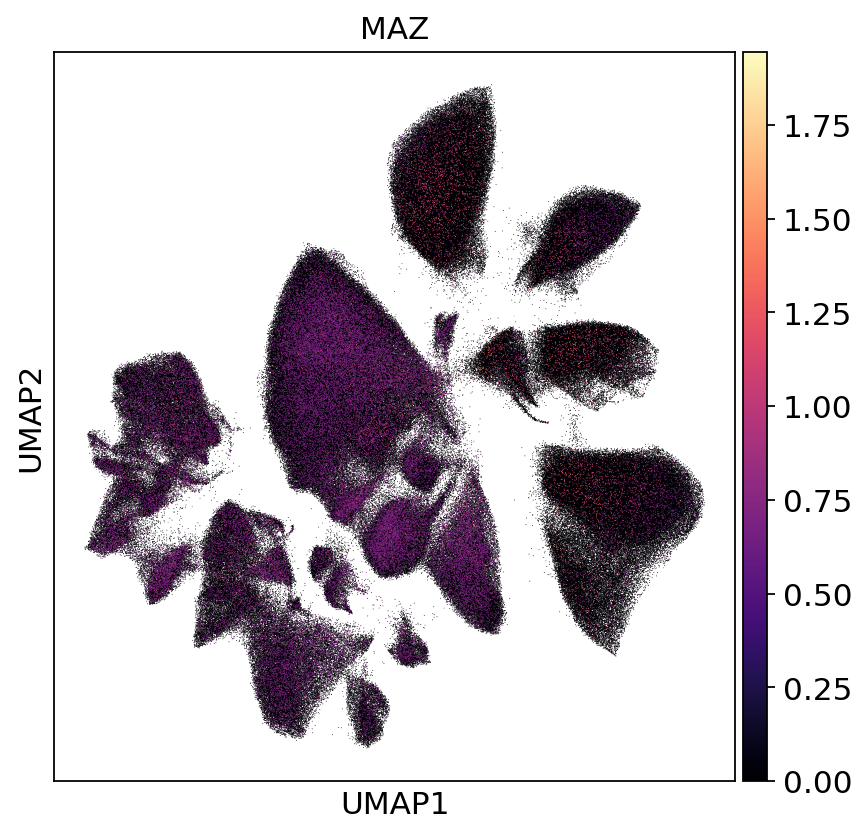

In [12]:
sc.pl.umap(adata, color=["MAZ"], 
           size=500000 /adata.n_obs, 
           frameon=True, 
           color_map = 'magma',
           save="_GeneExamples_MAZ.pdf")

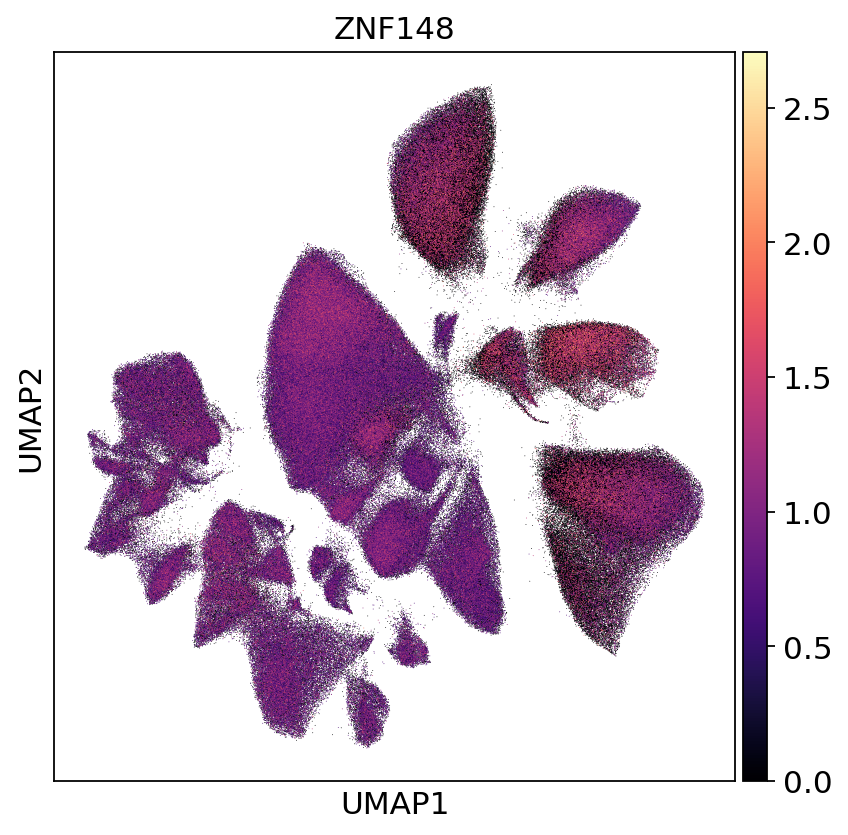

In [13]:
sc.pl.umap(adata, color=["ZNF148"], 
           size=500000 /adata.n_obs, 
           frameon=True, 
           color_map = 'magma',
           save="_GeneExamples_ZNF148.pdf")

In [14]:
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [15]:
grouped_obs_mean(adata[:,['SLIT2', 'KCNQ3', 'HCN2', 'INO80E', 'KLF4', 'MAZ', 'ZNF148']], "ctAnna_r1")

Astro_FB  Astro_PP  Endothelial  Exc_L2-3  Exc_L3-5  Exc_L4-6_1  \
SLIT2   0.086770  0.082188     0.262168  0.670570  0.419677    0.316718   
KCNQ3   0.643796  0.768411     0.692574  0.822593  1.630420    1.461758   
HCN2    0.007211  0.007605     0.035804  0.070204  0.083828    0.099809   
INO80E  0.031796  0.028925     0.033986  0.053623  0.057084    0.067714   
KLF4    0.003156  0.001663     0.050196  0.000620  0.000513    0.000364   
MAZ     0.028381  0.027512     0.042714  0.078557  0.130023    0.118214   
ZNF148  0.218568  0.241137     0.284714  0.446544  0.486815    0.410929   

        Exc_L4-6_2  Exc_L4-6_3  Exc_L5-6  Exc_L5-6_HTR2C  In_LAMP5  \
SLIT2     0.349585    0.185505  0.140048        0.137322  0.775884   
KCNQ3     1.559237    1.298335  1.124591        1.298934  1.360878   
HCN2      0.093328    0.087349  0.091306        0.112064  0.144179   
INO80E    0.044606    0.070641  0.068424        0.055488  0.063905   
KLF4      0.000375    0.000910  0.000275        0.000333  0.000275   
MAZ       0.105636    0.089473  0.092016        0.093611  0.135099   
ZNF148    0.419856    0.377209  0.408453        0.464673  0.466703   

        In_PVALB_Ba  In_PVALB_Ch   In_RELN    In_SST    In_VIP  Microglia  \
SLIT2      1.664589     0.956308  0.100427  0.610545  0.356984   0.190516   
KCNQ3      0.965530     1.210975  1.367868  1.263785  1.022818   1.745293   
HCN2       0.199684     0.141535  0.100181  0.086067  0.099524   0.008290   
INO80E     0.054498     0.037547  0.047022  0.039519  0.040708   0.038975   
KLF4       0.000585     0.000929  0.000604  0.000509  0.000296   0.001812   
MAZ        0.091085     0.062685  0.102799  0.076603  0.087294   0.032807   
ZNF148     0.445855     0.413251  0.413167  0.441788  0.410831   0.345434   

             OPC  Oligodendrocyte  
SLIT2   0.076370         0.296289  
KCNQ3   0.625116         0.676482  
HCN2    0.017753         0.092966  
INO80E  0.029688         0.028424  
KLF4    0.000535         0.000373  
MAZ     0.030419         0.031425  
ZNF148  0.337012         0.223215